# Mini-Project: Computing the Permanent with Monte Carlo Methods

**STAN48 - Programming for Data Science**

This notebook demonstrates how Monte Carlo methods and variance reduction transform an intractable problem into a solvable one.

In [70]:
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import permutations
import time
np.random.seed(222)


## 1. The Permanent: Definition and Naive Computation

The permanent of an n×n matrix is like the determinant, but without alternating signs:

$$\text{perm}(A) = \sum_{\sigma \in S_n} \prod_{i=1}^{n} A_{i,\sigma(i)}$$

In [64]:
def permanent_exact(A):
    """Compute permanent exactly (only feasible for small matrices)"""
    n = len(A)
    total = 0
    for perm in permutations(range(n)):
        product = 1
        for i in range(n):
            product *= A[i][perm[i]]
        total += product
    return total

# Test on small matrices
A_tiny = np.array([[1, 2], [3, 4]])
print(f"2 by 2 matrix permanent: {permanent_exact(A_tiny)}")
print(f"Compare to determinant: {np.linalg.det(A_tiny):.0f}")

2 by 2 matrix permanent: 10
Compare to determinant: -2


## 2. The Computational Challenge

Let's see how computation time explodes with matrix size:

In [65]:
# Measure computation time for different sizes
sizes = [2, 3, 4, 5, 6, 7, 8]
times = []

for n in sizes:
    A = np.random.rand(n, n)
    start = time.time()
    permanent_exact(A)
    elapsed = time.time() - start
    times.append(elapsed)
    print(f"n={n}: {elapsed:.4f}s ({math.factorial(n):,} permutations)")
    if elapsed > 1:  # Stop if it takes too long
        break



n=2: 0.0000s (2 permutations)
n=3: 0.0000s (6 permutations)
n=4: 0.0000s (24 permutations)
n=5: 0.0003s (120 permutations)
n=6: 0.0021s (720 permutations)
n=7: 0.0123s (5,040 permutations)
n=8: 0.0558s (40,320 permutations)


## 3. Naive Monte Carlo Solution

Instead of checking all n! permutations, we randomly sample some and estimate:

$$\text{perm}(A) \approx n! \times \text{(average value of sampled permutations)}$$

In [71]:
def permanent_naive_mc(A, n_samples=10000):
    """Naive Monte Carlo estimation"""
    n = len(A)
    estimates = []
    
    for _ in range(n_samples):
        # Random permutation
        perm = np.random.permutation(n)
        # Calculate product for this permutation
        product = np.prod([A[i, perm[i]] for i in range(n)])
        estimates.append(product)
    
    # Return n! times the average
    return math.factorial(n) * np.mean(estimates)

# Test on a 5×5 matrix
n = 10
A = np.random.rand(n, n)
true_perm = permanent_exact(A)

# Run naive MC multiple times to see variance
naive_results = [permanent_naive_mc(A, 1000) for _ in range(50)]

print(f"True permanent: {true_perm:.6f}")
print(f"Naive MC mean:  {np.mean(naive_results):.6f}")
print(f"Naive MC std:   {np.std(naive_results):.6f}")


True permanent: 3779.176761
Naive MC mean:  3703.422151
Naive MC std:   417.165148


## 4. Importance Sampling Solution

The idea: instead of sampling permutations uniformly, sample them proportionally to their contribution!

In [72]:
def permanent_importance_sampling(A, n_samples=10000):
    """Importance sampling estimation"""
    n = len(A)
    weights = []
    
    for _ in range(n_samples):
        available = list(range(n))
        weight = 1.0
        
        # Build permutation sequentially
        for i in range(n):
            # Calculate probabilities proportional to matrix elements
            row_values = [A[i, j] for j in available]
            row_sum = sum(row_values)
            
            if row_sum == 0:
                weight = 0
                break
            
            # Choose column with probability proportional to its value
            probs = [val/row_sum for val in row_values]
            chosen_idx = np.random.choice(len(available), p=probs)
            
            # Update weight 
            weight *= row_sum
            
            # Remove chosen column
            available.pop(chosen_idx)
        
        weights.append(weight)
    
    return np.mean(weights)

# Test importance sampling
importance_results = [permanent_importance_sampling(A, 1000) for _ in range(50)]

print(f"True permanent:     {true_perm:.6f}")
print(f"Importance MC mean: {np.mean(importance_results):.6f}")
print(f"Importance MC std:  {np.std(importance_results):.6f}")


True permanent:     3779.176761
Importance MC mean: 3803.791368
Importance MC std:  113.038817


## 5. Visual Comparison: Variance Reduction in Action

/var/folders/cv/h2_qmh3967l_b9scypv8xycw0000gn/T/ipykernel_55536/1680511537.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([naive_results, importance_results], labels=['Naive MC', 'Importance'])


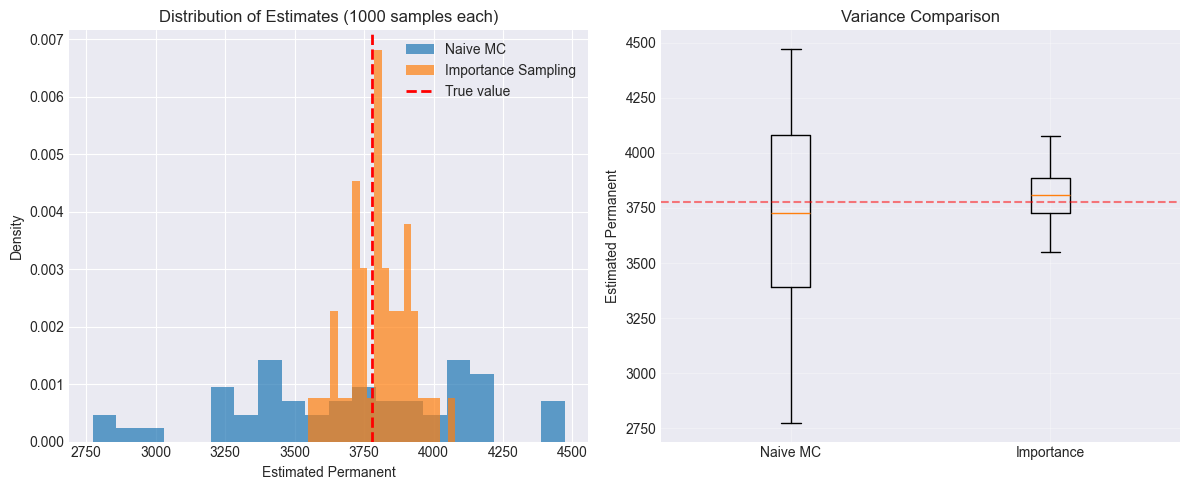


Variance reduction factor: 13.6x
 This means importance sampling needs 14x fewer samples for same accuracy!


In [74]:
# Compare distributions of estimates
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution plots
axes[0].hist(naive_results, bins=20, alpha=0.7, label='Naive MC', density=True)
axes[0].hist(importance_results, bins=20, alpha=0.7, label='Importance Sampling', density=True)
axes[0].axvline(true_perm, color='red', linestyle='--', linewidth=2, label='True value')
axes[0].set_xlabel('Estimated Permanent')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Estimates (1000 samples each)')
axes[0].legend()

# Box plot for variance comparison
axes[1].boxplot([naive_results, importance_results], labels=['Naive MC', 'Importance'])
axes[1].axhline(true_perm, color='red', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Estimated Permanent')
axes[1].set_title('Variance Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate variance reduction
variance_reduction = np.var(naive_results) / np.var(importance_results)
print(f"\nVariance reduction factor: {variance_reduction:.1f}x")
print(f" This means importance sampling needs {variance_reduction:.0f}x fewer samples for same accuracy!")

## 6. Convergence Analysis: How Fast Do They Converge?

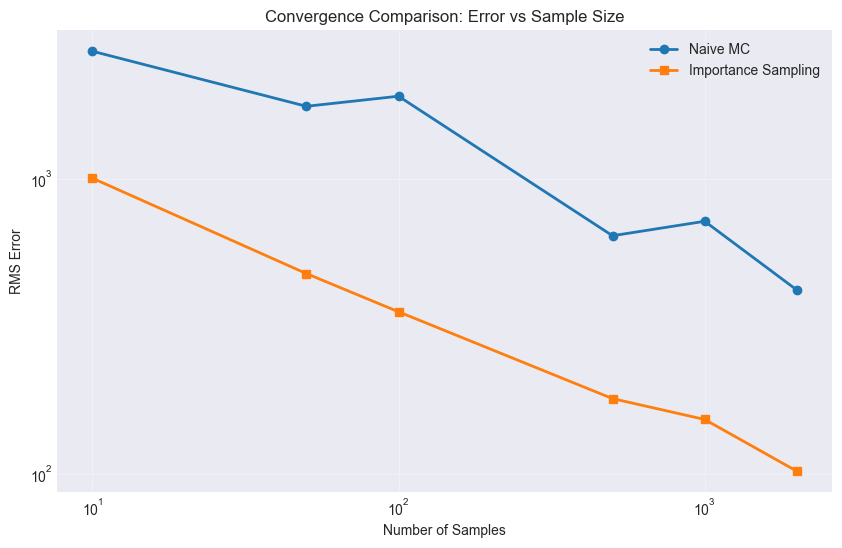

In [75]:
# Test convergence with different sample sizes
sample_sizes = [10, 50, 100, 500, 1000, 2000]
naive_errors = []
importance_errors = []

for n_samples in sample_sizes:
    # Run each method 20 times
    naive_ests = [permanent_naive_mc(A, n_samples) for _ in range(20)]
    importance_ests = [permanent_importance_sampling(A, n_samples) for _ in range(20)]
    
    # Calculate RMS error
    naive_errors.append(np.sqrt(np.mean((np.array(naive_ests) - true_perm)**2)))
    importance_errors.append(np.sqrt(np.mean((np.array(importance_ests) - true_perm)**2)))

# Plot convergence
plt.figure(figsize=(10, 6))
plt.loglog(sample_sizes, naive_errors, 'o-', label='Naive MC', linewidth=2)
plt.loglog(sample_sizes, importance_errors, 's-', label='Importance Sampling', linewidth=2)
plt.xlabel('Number of Samples')
plt.ylabel('RMS Error')
plt.title('Convergence Comparison: Error vs Sample Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## 7. Testing on a Challenging Matrix

Let's test on a matrix where importance sampling really shines:

In [76]:

# Create a diagonal-dominant matrix (challenging for naive MC)
n = 10
A_hard = np.ones((n, n)) * 0.1
np.fill_diagonal(A_hard, 2)

# This is still small enough to compute exactly
true_perm_hard = permanent_exact(A_hard)

# Compare methods
n_trials = 100
n_samples = 500

naive_hard = [permanent_naive_mc(A_hard, n_samples) for _ in range(n_trials)]
importance_hard = [permanent_importance_sampling(A_hard, n_samples) for _ in range(n_trials)]

print("Diagonal-Dominant Matrix (10 by 10):")
print("="*40)
print(f"True permanent: {true_perm_hard:.2f}")
print(f"\nNaive MC:")
print(f"  Mean:  {np.mean(naive_hard):.2f}")
print(f"  Std:   {np.std(naive_hard):.2f}")
print(f"  Error: {abs(np.mean(naive_hard) - true_perm_hard):.2f}")
print(f"\nImportance Sampling:")
print(f"  Mean:  {np.mean(importance_hard):.2f}")
print(f"  Std:   {np.std(importance_hard):.2f}")
print(f"  Error: {abs(np.mean(importance_hard) - true_perm_hard):.2f}")


Diagonal-Dominant Matrix (10 by 10):
True permanent: 1186.66

Naive MC:
  Mean:  45.11
  Std:   160.46
  Error: 1141.56

Importance Sampling:
  Mean:  1192.93
  Std:   103.23
  Error: 6.27
